In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch

from raytracerthing import RayTracerThing, Activations

np.random.seed(42)

In [2]:
digits = load_digits()
digits.keys()

y = digits['target']

X = digits['images']
X = X[y < 2]
X = X / X.max()
N = X.shape[0]
image_shape = X.shape[1:]

print(N, image_shape)

y = y[y < 2]

print(y[:5])

360 (8, 8)
[0 1 0 1 0]


In [3]:
np.unique(y, return_counts=True)

(array([0, 1]), array([178, 182]))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
%%time

layer_shape = image_shape

clf = RayTracerThing(input_shape=image_shape,
                     hidden_layer_shape=layer_shape, 
                     n_layers=3,
                     activation_func=lambda x: Activations.sigmoid(x, alpha=8),
                     learning_rate=0.1)

CPU times: user 29.2 ms, sys: 4.53 ms, total: 33.8 ms
Wall time: 28.2 ms


In [6]:
%time clf.fit(X, y, n_epochs=1000)

Epoch 1000 of 1000 - train_loss: 0.1047 - train_acc: 0.9722 - val_loss: 0.1071 - val_acc: 0.9722
CPU times: user 6.55 s, sys: 145 ms, total: 6.69 s
Wall time: 6.52 s


In [7]:
y_pred = clf.predict(X_test)

In [8]:
val_accuracy = 1 - torch.mean(torch.abs(y_pred - torch.tensor(y_test, dtype=torch.float64)))
val_accuracy

tensor(0.9861)

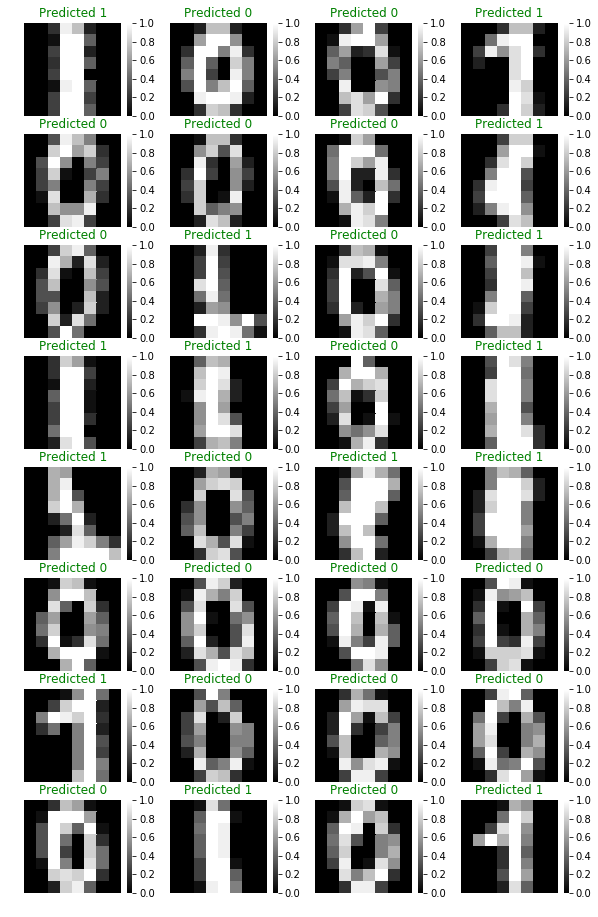

In [9]:
n_rows = 8
n_cols = 4
n_total = n_rows * n_cols
n_total = min(n_total, N)

width_ratio = 2.7
height_ratio = 2

figsize = (int(width_ratio * n_cols), int(height_ratio * n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.ravel()

for ax, image, expected, actual in zip(axes, X_test[:n_total], y_test[:n_total], y_pred[:n_total]):
    sns.heatmap(image, vmin=0.0, vmax=1.0, cmap='gray', ax=ax)
    ax.set_axis_off()

    color = 'green' if expected == actual else 'red'
    ax.set_title('Predicted %d' % actual, color=color)

plt.show()

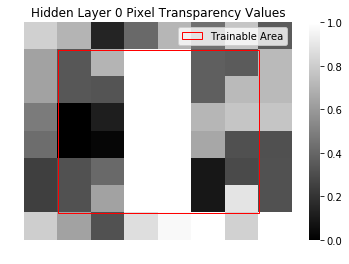

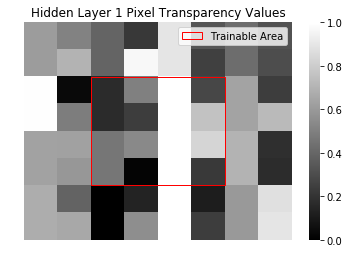

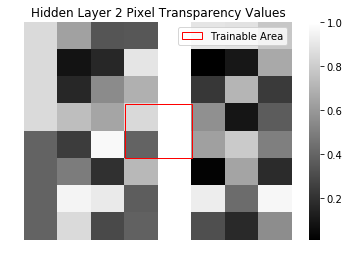

In [10]:
for i, layer in enumerate(clf.hidden_layers):  
    trained_pixels = clf.grid_W_map[i].keys() 
    
    min_extent = clf.layer_shape
    max_extent = (0, 0)
    
    for grid_coord in trained_pixels:
        row, col = grid_coord
        
        if row < min_extent[0]:
            min_extent = (row, min_extent[1])
            
        if row > max_extent[0]:
            max_extent = (row, max_extent[1])
            
        if col < min_extent[1]:
            min_extent = (min_extent[0], col)
            
        if col > max_extent[1]:
            max_extent = (max_extent[0], col)
            
    height = (max_extent[0] - min_extent[0]) + 1
    width = (max_extent[1] - min_extent[1]) + 1

    ax = sns.heatmap(layer.pixel_values, cmap='gray')
    ax.set_axis_off()
    ax.set(title='Hidden Layer %d Pixel Transparency Values' % i)
        
    rect = patches.Rectangle(min_extent, width, height, linewidth=1, edgecolor='r', facecolor='none', label='Trainable Area')

    ax.add_patch(rect)
    ax.legend()
    plt.show()